In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

%matplotlib inline


In [4]:
df = pd.read_csv("SpotifyFeatures.csv")
print("Original shape:", df.shape)
df.head()


Original shape: (232725, 18)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [5]:
drop_cols = ['track_id', 'track_name', 'artist_name']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

for c in df.select_dtypes(include=['object']).columns:
    if df[c].nunique() <= 50:
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c].astype(str))
    else:
        df = df.drop(columns=[c])

df = df.fillna(0)

print("Cleaned dataset shape:", df.shape)
df.head()

Cleaned dataset shape: (232725, 15)


,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,15,0,0.611,0.389,99373,0.910,0.000,4,0.3460,-1.828,0,0.0525,166.969,3,0.814
1,15,1,0.246,0.590,137373,0.737,0.000,9,0.1510,-5.559,1,0.0868,174.003,3,0.816
2,15,3,0.952,0.663,170267,0.131,0.000,3,0.1030,-13.879,1,0.0362,99.488,4,0.368
3,15,0,0.703,0.240,152427,0.326,0.000,4,0.0985,-12.178,0,0.0395,171.758,3,0.227
4,15,4,0.950,0.331,82625,0.225,0.123,8,0.2020,-21.150,0,0.0456,140.576,3,0.390


In [6]:
X = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Final feature matrix shape:", X_scaled.shape)


Final feature matrix shape: (232725, 15)


In [7]:
iso = IsolationForest(contamination=0.01, random_state=42)
iso_pred = iso.fit_predict(X_scaled)

df["iso_score"] = -iso.decision_function(X_scaled)
df["iso_anomaly"] = (iso_pred == -1).astype(int)

iso_anomalies = df["iso_anomaly"].sum()
iso_pct = iso_anomalies / len(df) * 100

print(f"✅ Isolation Forest: {iso_anomalies} anomalies out of {len(df)} rows ({iso_pct:.2f}%).")
print(df[["iso_score", "iso_anomaly"]].head())

✅ Isolation Forest: 2328 anomalies out of 232725 rows (1.00%).
   iso_score  iso_anomaly
0  -0.099964            0
1  -0.107889            0
2  -0.090370            0
3  -0.107596            0
4  -0.088438            0


In [14]:
import os, warnings
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  
warnings.filterwarnings("ignore")

from sklearn.neighbors import LocalOutlierFactor


df_sample = df.sample(n=20000, random_state=42)
X_sample = df_sample.select_dtypes(include=[np.number])
X_sample_scaled = scaler.fit_transform(X_sample)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, n_jobs=-1)
lof_pred = lof.fit_predict(X_sample_scaled)
lof_scores = -lof.negative_outlier_factor_

df_sample["lof_score"] = lof_scores
df_sample["lof_anomaly"] = (lof_pred == -1).astype(int)

lof_anomalies = df_sample["lof_anomaly"].sum()
lof_pct = lof_anomalies / len(df_sample) * 100

print(f"✅ LOF (sample 20k): {lof_anomalies} anomalies out of {len(df_sample)} rows ({lof_pct:.2f}%).")
print(df_sample[["lof_score", "lof_anomaly"]].head())


✅ LOF (sample 20k): 200 anomalies out of 20000 rows (1.00%).
        lof_score  lof_anomaly
788      1.005443            0
207109   1.004112            0
138644   1.079448            0
37164    1.045688            0
174351   0.989498            0


In [15]:
df.to_csv("anomaly_results_iso.csv", index=False)
df_sample.to_csv("anomaly_results_lof.csv", index=False)

print("✅ Results saved: anomaly_results_iso.csv (full) and anomaly_results_lof.csv (sample)")

✅ Results saved: anomaly_results_iso.csv (full) and anomaly_results_lof.csv (sample)


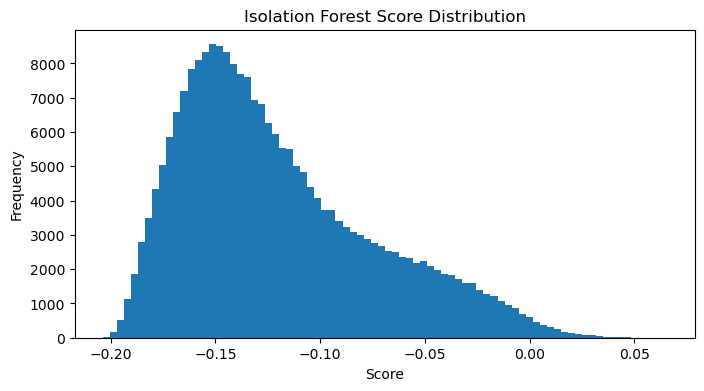

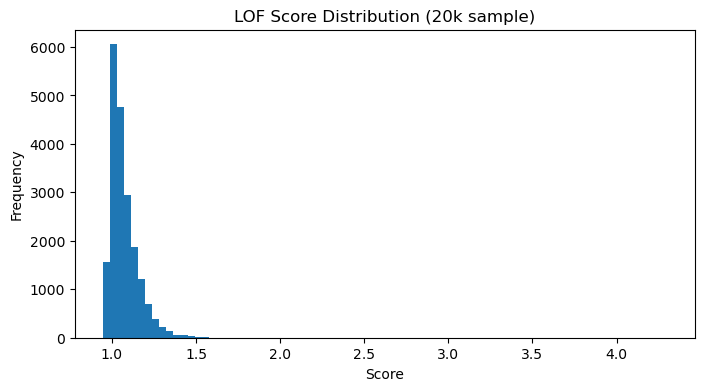

In [16]:
plt.figure(figsize=(8,4))
plt.hist(df["iso_score"], bins=80)
plt.title("Isolation Forest Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df_sample["lof_score"], bins=80)
plt.title("LOF Score Distribution (20k sample)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()
